We use the pulse shapes obtained by solving the LZ problem with $(\alpha, \beta)$
hypergeometries, given by $f_i(\tau)$, with $\tau\in\left[0,1\right]$. However, the basis of functions is overcomplete. To obtain the minimal subset of basis elements $\tilde{f}_i(\tau)$, we perform a QR decomposition.

A general function $g(\tau)$ can be approximated as
$$
g(\tau)\approx \sum_i c_i\tilde{f}_i(\tau).
$$
Since our basis is non-orthogonal, the coefficients $c_i$ can be obtained by solving the lineal system
$$
\tilde{G} \vec{c}= \vec{b},
$$
where $\tilde{G}_{ij} = \langle \tilde{f}_i|\tilde{f}_j\rangle$ are the components of the Gram matrix, and $b_i = \langle g|\tilde{f_i}\rangle$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import romb
from scipy.linalg import qr, solve
from tqdm.auto import tqdm

from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.parallel_utils import parameter_run

In [3]:
alphas = np.linspace(-25, 60, 201)  # Increase to lower the error
alphas[0] = -np.inf
alphas[-1] = np.inf

beta = 0

zs_sol = parameter_run(solve_LZ, 'alpha', alphas, beta=beta, reduction=3)
s = np.linspace(0, 1, len(zs_sol[0]))

solve_LZ: [['alpha']]:   0%|          | 0/201 [00:00<?, ?it/s]

In [4]:
N = len(zs_sol)
ds = np.abs(s[1] - s[0])

G = np.zeros((N, N))

pbar = tqdm(range(N))
for i in pbar:
    G[i, :] = romb(zs_sol[i] * zs_sol, dx=ds, axis=-1)

  0%|          | 0/201 [00:00<?, ?it/s]

In [5]:
Q, R, pivot_indices = qr(G, pivoting=True)
tolerance = 1e-10
rank = np.sum(np.abs(np.diag(R)) > tolerance)

independent_indices = sorted(pivot_indices[:rank])

In [6]:
independent_functions = [zs_sol[i] for i in independent_indices]

# Recompute the Gram matrix for the independent functions
G_independent = G[independent_indices, :][:, independent_indices]

In [7]:
def cubic(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x ** 2 + a3 * x ** 3
a0 = -10
a1 = 100
a2 = 60 - 3 * a1
a3 = -40 + 2 * a1
g = cubic(s, a0, a1, a2, a3)

b = np.zeros(rank)
for i in range(rank):
    b[i] = romb(g * independent_functions[i], dx=ds)

c = solve(G_independent, b)
g_approx = np.sum(c[:, None] * independent_functions, axis=0)

print(a0, a1, a2, a3)

-10 100 -240 160


error=1.674468093899744e-05


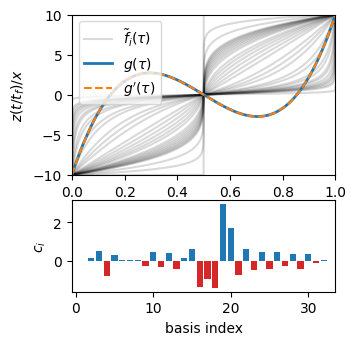

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(3.4, 3.6), gridspec_kw={'height_ratios': [1.75, 1]})

one_legend = False
for fun in independent_functions:
    if not one_legend:
        label = r'$\tilde{f}_i(\tau)$'
        one_legend = True
    else:
        label = None
    axs[0].plot(s, fun, c='k', alpha=0.15, label=label)

axs[0].plot(s, g, label=r'$g(\tau)$', linewidth=2, c='tab:blue')
axs[0].plot(s, g_approx, '--', label=r'$g^\prime(\tau)$', c='tab:orange', linewidth=1.5)

axs[0].legend(frameon=True, framealpha=0.75, loc=0)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(-10, 10)
axs[0].set_xlabel(r'$t / t_f$')
axs[0].set_ylabel(r'$z(t / t_f) / x$')

error = np.sum(np.abs(g - g_approx)) / len(g)
print(f'{error=}')

axs[1].bar(np.arange(rank)[c > 0], c[c > 0])
axs[1].bar(np.arange(rank)[c < 0], c[c < 0], color='tab:red')
axs[1].set_ylabel(r'$c_i$')
axs[1].set_xlabel('basis index')
axs[1].set_xlim(-0.5, rank - 0.5);